# Empirical Techniques for Modeling Imbalanced Binary Tabular Datasets

We explore various techniques to predict (very) imbalanced datasets, via feature engineering, data sampling and varied machine learning models. We do not try to find the very best model (and associated hyperparameters) for a given dataset. Rather, we study the impact of different approaches and techniques on the *direction* of various algoritms. We summarized our findings, based on a collection of datasets at https://docs.google.com/document/d/16Hr76mYMeTO8Yvykn6mI376-I3TitgLcNi5_ZkJvhAw

## Imports

In [919]:
import numpy as np
from numpy.random import seed
import pandas as pd
from pandas import get_dummies
import sweetviz as sw
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score,recall_score
import catboost
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,NuSVC
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
import re
import scipy.stats as stats
from scipy.stats import chi2_contingency , spearmanr
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
import shap
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.models.auto_encoder import AutoEncoder

### Miscelaneous

In [920]:
# TESTING params, should be all set to zero when custom parameters are set and final run on entire dataset is performed.
goFast=0 #set to 1 for fast processing, only one model used: catboost
doViz =0 #This step can take some time so if program is run multiple times, we may want to set it to 0
debugLevel=0 # typically maps to model verbose levels 0 or 1.
  
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

## Import data

In [921]:
# CUSTOM IMPLEMENTATION

#use sample files
# proprietary
#testFile='proprietary'
# public
testFile='defaultCreditCard' # https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
#testFile='kaggleInsurance' # https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice

if testFile=='proprietary':
    df=pd.read_pickle('C:/Users/plermant/git/ML/PP/ATO/ato_fraud_data.pkl')
    df=df.sample(frac=0.5)
if testFile=='defaultCreditCard':
    df=pd.read_csv('C:/Users/plermant/git/sampleFiles/defaultCreditCardClients.csv')
if testFile=='kaggleInsurance':
    df=pd.read_csv('C:/Users/plermant/git/sampleFiles/kaggleInsurance.csv') 
# END CUSTOM IMPLEMENTATIONS

## Set Global Variables
Global variables are project dependent and need to be set thoughtfully. We provide default values so program will run 'out of the box'.

In [922]:
# SYSTEM PARAMETER
# Revisit defaults below according to your dataset and business goals.

# automatically drops columns with more than dropPercent null values
dropPercent=10 
# ratio used to determine outliers - No outlier is dropped by default, regardless of this value setting.
outlierIqrRatio = 1.5
# Cramer's V threshold is uses to assess if 2 categorical features are dependent. If over threshold, they get removed
cramersThreshold=0.9
# we will remove features whose variance multipled by ratio positive/negative label is smaller than varianceThreshold
varianceThreshold = .1
# Parameters to decide how/if to create an 'other' category when performing one-hot encoding on long-tailed distribution
dummyMaxCount = 10 # no more than 10 new features created as a result of one-hot encoding
otherLabel="otherOH" # label name used to consolidates all labels beyond dummyMaxCount
dummyOtherMaxPercent = .05 # the 'other' feature can hold up to this percentage of the distribution.
percentHoldout = 0.3 # percentage of overall dataset to perform validation after training
# main metric to train all models for
mainMetric="roc_auc" # f1 or roc_auc
# correlation threshold, over wich features get removed
corrThreshold = 0.9
permutationTreshold=0.00001 # Will select (and remove) features that are below this threshold thru permutation
shapThreshold=0.001 #  Will select (and remove) features that are below this threshold thru shap
imbalanceLossWeightRatio=10 # in one experiment, we set the loss ratio to give more weight to minority class, with ratio here.
randomSeed=10 # used for reprocibility
tf.keras.utils.set_random_seed(randomSeed)
seed(randomSeed)

#model default definition
allModels=[] # holds all the models to be evaluated in this notebook
m={'name':'catboost','handle':CatBoostClassifier(silent=True,random_state=randomSeed),'type':'sklearn'}
allModels.append(m)
if goFast==0:
    m={'name':'logregress','handle':LogisticRegression(random_state=randomSeed),'type':'sklearn'}
    allModels.append(m)
    m={'name':'ffnn','handle':"defined inside processKeras function",'type':'keras'} # "defined inside processKeras function"
    epochCount=100 # Large value, however earlyStopping on validation loss is implemented
    allModels.append(m)
    m={'name':'iForest','handle':"defined inside processAnomaly function",'type':'anomaly'} # "defined inside processAnomaly function"
    allModels.append(m)
    m={'name':'autoencoder','handle':"defined inside processAnomaly function",'type':'anomaly'} # "defined inside processAnomaly function"
    allModels.append(m)
    epochAutoencoder=10 # for autoencoder models only

In [923]:
# BUSINESS DRIVEN PARAMETERS
# Must be set according to business knowledge
#  Some piror EDA may have to be performed first by setting top doViz to one in top cell.

# Required
target="" 
# Must be 1.  Means that a hit is marked as targetPositive in target column. 
targetPositive=1

# Not required
# Features to drop as they don't hold any predictive powers, like item ID
columnsToDrop=[] # requires business input
# List feature names known to be dateTime 
dateTimeList=[]
# List discrete numeric features that should be categories (nemeric without ranking meaning, like integer color value )
numericCat=[]
#list non-datetime object types known to *not* be categories
notCategory=[] 
# Dictionary of dictionary labels:values , i.e. string categories with rank, like education levels
ordinalCategory={} # e.g. {'education':{'noEdu':0,'highSchool':1,'higher':2},{...}}
# when an ordinal catagory column is replaced by numbers, its name will be appended with subOrdinal featureName becomes featureNamesubOrdinal
subOrdinal="ord_" 
    
if testFile=='proprietary':
    # set dataset target name 
    target="is_bad"
    # Features to drop as they don't hold any predictive powers
    columnsToDrop=['account_number_driver']
    # List feature names known to be dateTime 
    dateTimeList=['run_date']
    # List discrete numeric features that should be categories (nemeric without ranking meaning, like integer color value )
    numericCat=['paper_credit_mktg_pref_y_n','cust_acct_type_code','actv_slr_y_n','cust_categ_code','count_email_domain']
elif testFile=='defaultCreditCard':
    # set dataset target name 
    target="default"
    numericCat=['SEX','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
    # Features to drop as they don't hold any predictive powers
elif testFile=='kaggleInsurance':
    target="Response"
    columnsToDrop=['id']
    ordinalCategory={'Vehicle_Age':{'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}} # e.g. {'education':{'noEdu':0,'highSchool':1,'higher':2},{...}}
else: 
    print("PICK a file !!!!!!!")
    exit(1)


In [924]:
# print main metrics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Target feature details
We'll remove unlabeled target samples as we cannot use them

In [925]:
# Remove unlabeled samples
before=len(df)
df = df[df[target].notnull()]
print('We removed',before-len(df),'rows that had null target values')

unique, counts = np.unique(df[target], return_counts=True)
print('\nNumber of unique values and percentages for the target',target,':')
val=np.asarray((unique, counts)).T
for i in range(len(val)):
    print(val[i][1],'samples labeled',val[i][0],', or',round(100.0* val[i][1]/len(df[target]) ,2),'percent')
positivePercent=round(1.0* val[1][1]/len(df[target]) ,4)


We removed 0 rows that had null target values

Number of unique values and percentages for the target default :
23364 samples labeled 0 , or 77.88 percent
6636 samples labeled 1 , or 22.12 percent


### Drop meaningless features
Meaningless features do not have any predictive power, like sample ids, or features with constant values.

In [926]:
# drop columns with uniform values

for c in df.columns:
    if len(df[c].unique())==1:
        columnsToDrop.append(c)

for c in columnsToDrop: 
    if c in df.columns: # in case this code was already run
        df.drop(columns=c,inplace=True)
        print('Removing feature',c,'because all values are the same or in business parameter list columnsToDrop')

## Basic information and visualization

In [927]:
df.info()
print(df.columns)
df.head()
if doViz==1:
    report=sw.analyze(df,pairwise_analysis='off')
    report.show_html('out_html',open_browser=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

## Set data proper types
This step will reduce memory size and allow for proper data manpulation. End result will only contain 'category', int64 or float64 types.

### Turn object type into category, dateTime etc ... when appropriate

In [928]:
#columnTypeMetrics(df,'object') #Let's take a look at object columns first
def columnTypeMetrics(dfin,ctype):
    if len(dfin.select_dtypes(include=[ctype]).columns) > 0:
        objColumns=dfin.select_dtypes(include=[ctype]).columns
        print("\nMain metrics for the",len(objColumns),ctype,"columns:")
        for c in objColumns:
            print("\nFeature",c, 'is of type',dfin[c].dtypes, 'with following unique values:')
            print(dfin[c].unique())
    else: print('No column of type',ctype)

# Handle DateTime features
for c in dateTimeList: 
    if debugLevel > 0: print("Turned feature",c,"from object to dateTime")
    df[c]=pd.to_datetime(df[c],errors='raise') # turn object into dateTime

# Handle categories features
for c in df.select_dtypes(include=['object']).columns:
    if c not in dateTimeList and c not in notCategory :
        df[c]=df[c].astype('category')
        if debugLevel > 0: print("Turned feature",c,"from object to category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

### Turn discrete numeric values into categories when appropriate

In [929]:
# Turn discrete numerical values without order meaning into categories

for c in numericCat:
    df[c] = df[c].astype('object')
    if debugLevel > 0: print("Turned feature",c,"from numeric to object")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  int64 
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  int64 
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  int64 
 5   PAY_0      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  int64 
 12  BILL_AMT2  30000 non-null  int64 
 13  BILL_AMT3  30000 non-null  int64 
 14  BILL_AMT4  30000 non-null  int64 
 15  BILL_AMT5  30000 non-null  int64 
 16  BILL_AMT6  30000 non-null  int64 
 17  PAY_AMT1   30000 non-null  int64 
 18  PAY_AMT2   30000 non-null  int64 
 19  PAY_AMT3   30000 non-null  int64 
 20  PAY_AMT4   30000 non-null  i

## Turn DateTime features into numeric or categorical values
This step needs business input and may result in either continuous or discrete values

In [930]:
# CUSTOM IMPLEMENTATION
if testFile=='proprietary':
# For the sake of excercise, we compute the time difference between the values and a fixed datedf['run_date_diff'] = (pd.to_datetime( df['run_date'])-pd.to_datetime('2020-01-01')).dt.days
    df['run_date_diff']=(pd.to_datetime( df['run_date'])-pd.to_datetime('2020-01-01')).dt.days
    df.drop(columns='run_date',inplace=True)
    df.info()

## Handle missing data
Note that a missing piece of information may materialize in different ways: nan (numeric),naT (dateTime), None (object), but also as a number (e.g. 0 or -1), or other strings (e.g. "None","?", "-"). How to fill in missing data needs business input, however it is typically safe to remove entire rows that are missing values if their number is relatively small.

In [931]:
def nullColumns(dfin,dropPercent): #prints non-null percentage of missing values per column
    print('\nColumns with non-zero percent of missing values:')
    input=dfin.isnull().sum()/len(dfin) #holds non-null percentage of missing values per column
    found=0
    res=[]
    if len(input) >0:
        for j in range (len(input)):
            if input[j]>0:
                print(input.index[j],round(100.0*input[j],2),'% of null values')
                if round(100.0*input[j],2) > dropPercent:
                    res.append(input.index[j])
                found=1
    if found==0: print('No column has null values')
    return res
        
def nullRows(dfin): #prints number and percentage of rows with at least one null
    nullRows=dfin[dfin.isnull().any(axis=1)]# rows where there are at least one null
    print('\nNumber of rows with at least one null value is',len(nullRows),', about',round(100.0*len(nullRows)/len(dfin),2),'percent of all rows')
         
#Let's identify the number of rows with at least one nan/None and the percentage of nulls per columns
nullRows(df)
# Let's check the target values of rows with missing data 
#print('Number of rows with at least one null value with positive target:',len(df[df.isnull().any(axis=1)][df[target]==targetPositive]))
tmp=df[target]
print('Number of rows with null target:',len(tmp[tmp.isnull()]))
colToDrop=nullColumns(df,dropPercent)

# Let's drop the columns with dropPercent or more missing values and see how many rows are still null
#if 'cust_recv_actvtn_chnl_code' in df.columns: df.drop(columns=['cust_recv_actvtn_chnl_code'],inplace=True)
df.drop(columns=colToDrop,inplace=True)
print('\nAfter dropping columns with more than',dropPercent,'% of null values:')
nullRows(df)
nullColumns(df,dropPercent)

# Let's check the target values of rows with missing data 
tmp=df[target]
print('\nNumber of rows with null  target:',len(tmp[tmp.isnull()]))




Number of rows with at least one null value is 0 , about 0.0 percent of all rows
Number of rows with null target: 0

Columns with non-zero percent of missing values:
No column has null values

After dropping columns with more than 10 % of null values:

Number of rows with at least one null value is 0 , about 0.0 percent of all rows

Columns with non-zero percent of missing values:
No column has null values

Number of rows with null  target: 0


In [932]:
# CUSTOM IMPLEMENTATIONS

# implement business specific methods, including row deletion,filling-in etc ...
    
if testFile=='proprietary':
    #only few null rows have positive target, so OK to remove null rows
    print('Dropping rows with at least one null value')
    df.dropna(axis=0,inplace=True)
    #let's deal with rows that have "None" strings meaning null
    if (len(df[(df == 'None').any(axis=1)]) > 0): 
        print('Number of rows with value None in at least one column:',len(df[(df == 'None').any(axis=1)]))
        print('Dropping rows with value None in at least one columns')
        df = df.drop(df[(df == 'None').any(axis=1)].index)
    print('Number of rows with value None in at least one column:',len(df[(df == 'None').any(axis=1)]))
    #columnTypeMetrics(df,'category')

    #Finally, column prmry_cc_type_code seems to have entries with "#" values
    print('\nNumber of rows with # in column prmry_cc_type_code:',len(df[df.prmry_cc_type_code== "#"]))
    #for now let's treat # as a valid category, we can revisit this later, based on business input
# END CUSTOM IMPLEMENTATIONS
# We now check that only 2 types remain, categories and numbers:

if debugLevel > 0: df.info()

## Outliers analysis
For numerical data only

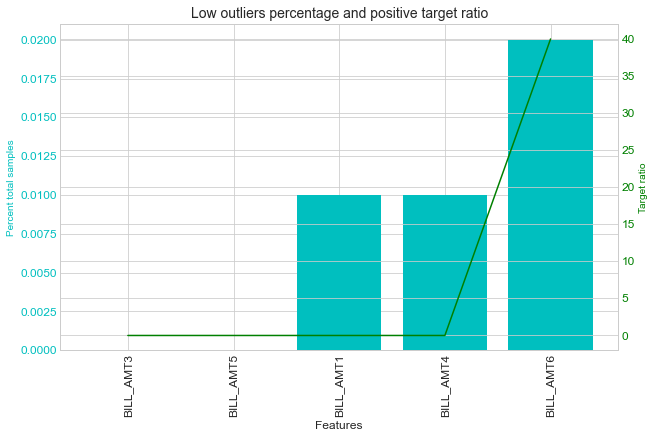

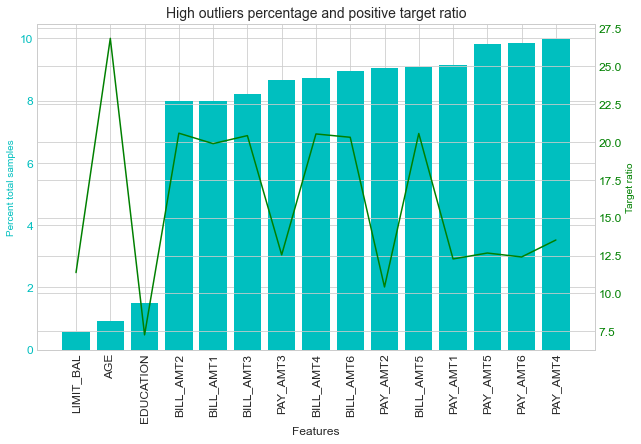

In [933]:
def computeOutliers(data):# For each numerical feature, compute the number and percentage of outliers, per inter-quartile rule, and their ratio of positive target
    # We'll use these numbers to decide how to deal with numerical outliers
    resp=[]
    numColumns=data.select_dtypes(include=['float64','int64']).columns
    outLow={} # storing outliers info in the form of {columnName:[lowCount,lowPercent,lowTargetRatio]}
    outHigh={} # storing outliers info in the form of {columnName:[highCount,highPercent,highTargetRatio]}

    for c in numColumns:
        q3 = data[c].quantile(.75)
        q1 = data[c].quantile(.25)
        IQR = q3 - q1
        upper = q3 + outlierIqrRatio * IQR
        lower = q1 - outlierIqrRatio * IQR
        u=data[data[c] > upper]
        l=data[data[c] < lower]
        uCount=len(u)
        uPercent=round(100.0*uCount/len(data[c]),2)
        if len(u) > 0: uTargetRatio=round(100*len(u[u[target]==targetPositive])/len(u),2)
        lCount=len(l)
        lPercent=round(100.0*lCount/len(data[c]),2)
        if len(l) > 0: lTargetRatio=round(100*len(l[l[target]==targetPositive])/len(l),2)
        if uCount>0 and IQR != 0:
    #         print(c,'high value:',upper, ', # of high:',uCount,', % of high:',uPercent)
    #         print("Ratio of positive target for high outliers:",uTargetRatio)
            outHigh[c]=[uCount,uPercent,uTargetRatio]
        if lCount>0 and IQR != 0:
    #         print(c,'Low value:',lower,', # of low:',lCount,', % of low:',lPercent)
    #         print("Percent of positive target for low outliers:",lTargetRatio)
            outLow[c]=[lCount,lPercent,lTargetRatio]    
    #sort from low to high percentages
    outLow=dict(sorted(outLow.items(), key=lambda item: item[1]))
    outHigh=dict(sorted(outHigh.items(), key=lambda item: item[1]))
    resp.append(outLow)
    resp.append(outHigh)
    return resp

def removeOutliers(data): # returns indexes to outlier rows
    remove=data.copy() # we don't want to modify data
    numColumns=remove.select_dtypes(include=['float64','int64']).columns
    for c in numColumns:
        q3 = remove[c].quantile(.75)
        q1 = remove[c].quantile(.25)
        IQR = q3 - q1
        upper = q3 + outlierIqrRatio * IQR
        lower = q1 - outlierIqrRatio * IQR
        if IQR != 0:
            before=remove.shape
            remove = remove[remove[c] < upper]
            remove = remove[remove[c] >  lower]
            if before != remove.shape:
                print('Removing outliers for column=',c)
                print(remove.shape)
    return remove
        
# Let's graph this info
def plotOutliers(data,title):
    temp1=[]
    temp2=[]
    titleSize=14
    textSize=12
    for c in data:
        temp1.append(data[c][1])
        temp2.append(data[c][2])
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    ax.set_title(title,fontsize=titleSize)
    ax.set_xlabel("Features",fontsize=textSize)
    ax.set_ylabel('Percent total samples',color='c')
    ax.bar(data.keys(),temp1, label='Percent of total samples',color='c')
    ax.set_xticklabels(data.keys(),rotation = 90)
    ax.tick_params(axis='y', labelsize=textSize, labelcolor='c')
    ax.tick_params(axis='x', labelsize=textSize)
    ax2 = ax.twinx()
    ax2.plot(data.keys(),temp2, color='green', label='Target ratio')
    ax2.tick_params(axis='both', labelsize=textSize, labelcolor='green')
    ax2.set_ylabel('Target ratio',color='green')
    plt.show()

out=computeOutliers(df)
plotOutliers(out[0],"Low outliers percentage and positive target ratio")
plotOutliers(out[1],"High outliers percentage and positive target ratio")

In [934]:
# CUSTOM IMPLEMENTATIONS
#decide what outliers to remove, for instance the ones with less than 1% outlier and less than twice the positive target ratio.
# since we are dealing with imbalanced dataset, we will not remove outliers by default as they may hold important information.

## Remove duplicate rows

In [935]:
df.drop_duplicates(inplace=True)

In [936]:
if doViz==1:
    report=sw.analyze(df,pairwise_analysis='off')
    report.show_html('out_html',open_browser=True)

### Categorical initial feature independence
Perform initial categorical feature selection using Cramer's V metric and threshold (between 0 and 1)

In [937]:
#we'll apply Cramer's V to assess correlation between each category feature and the target
catdf=df.select_dtypes(exclude='number')
catDependent=[]
left=[]
err=[]
j=0
for c in catdf.columns:
    j=j+1
    for i in range (len(catdf.columns)):
        if i>=j:
            try:  
                crosstab =np.array(pd.crosstab(catdf[c],catdf[catdf.columns[i]], rownames=None, colnames=None)) # Cross table building
                stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
                obs = np.sum(crosstab) # Number of observations
                mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
                v=(stat/(obs*mini))
                #print('1st column:',c,'2nd column:',catdf.columns[i],'Cramers value:',v)
                if v > cramersThreshold:
                    catDependent.append(catdf.columns[i])
                else:
                    left.append(c)
            except:
                print("X2 could not be computed for feature",c,"with error: The internally computed table of expected frequencies has a zero element")
                err.append(c)
#dedupe
catDependent = list(dict.fromkeys(catDependent))

if len(err) > 0: print("Cramer's V could not be computed for following features,\nwith error: The internally computed table of expected frequencies has a zero element. These features will not be removed:",err)    
if len(catDependent) > 0: print("\nFollowing features will be dropped, as their cramer's V values are over threshold",cramersThreshold,":\n",catDependent)
else: print("No categorical feature will be dropped")
# if len(left) > 0: print("\nFollowing features will be preserved, as their cramer's V values are over threshold",cramersThreshold,":\n",left)
# else: print("No categorical feature is left!")

No categorical feature will be dropped


## Turn categorical features into numeric values

### Ordinal encoding
For string categories with rank, e.g. education levels

In [938]:
# handle ordinalCategory e.g. {'education':{'noEdu':0,'highSchool':1,'higher':2},{...}}

for f in ordinalCategory:
    if f in df.columns: # in case it was already performed
        name=subOrdinal+f
        df[f] = df[f].map(ordinalCategory[f])
        df.rename(columns = {f:name}, inplace = True)
        df[name] = df[name].astype('int64')
        if debugLevel > 0: print("Ordinal encoding feature",f,"into",name)

### One hot encoding
When number of categories is larger than dummyMaxCount, we substitute low frequency labels with otherLabel before one-hot encoding

In [939]:
def processOneHot(data):
    col=data.columns
    #first we consolidate all labels beyond dummyMaxCount into label named 'otherLabel'
    for i in range(len(col)):
        data[col[i]] = data[col[i]].astype('object') # need to set type to 'object' else won't be able to set a new label value
        if len(data[col[i]].value_counts()) > dummyMaxCount: # we have too many labels to one-hot encode them all
            tops=data[col[i]].value_counts().index[0:dummyMaxCount]
            print("feature",col[i],"has too many labels, we'll assign the -",otherLabel,"- label to all entries ranked below",dummyMaxCount)
            n=0
            for j in range(len(data)): #we are turning every label past the dummyMaxCount-th into otherLabel
                if(data[col[i]].iloc[j]) not in tops:
                    data[col[i]].iloc[j]=otherLabel      
                    n=n+1
            if debugLevel > 0: print("put",n,"items in", otherLabel," cat, out of total rows=",len(df))

    for i in range(len(col)):
        if debugLevel > 0: print("Feature",col[i],"will be one-hot encoded, resulting in names (one per label):",str(col[i])+"_label, skipping first label")
    
    return(get_dummies(data,drop_first=True,prefix=col,dtype="int64"))
    

In [940]:
# to test this cell only
# data=[['high6',0],['high1',2],['high2',0],['high',5],['high',0],['high5',0],['low',1],['med',7]]
# df=pd.DataFrame(data,columns=['tide','age'])
# print(df)
# dummyMaxCount=3

catdf=df.select_dtypes(exclude='number')
numericdf=df.select_dtypes(include='number')
print('numericdf shape',numericdf.shape)
targetdf=df[target]

if target in catdf.columns: catdf=catdf.drop(columns=[target])
print('catdf shape',catdf.shape)

if catdf.shape[1]>0:
    catdfoh=processOneHot(catdf)
    print('catdfoh shape',catdfoh.shape)

numericdf shape (29965, 16)
catdf shape (29965, 8)
feature PAY_0 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_2 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_3 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_4 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
catdfoh shape (29965, 62)


### Change float64 type to int64 when possible

In [941]:
#  columns with float64 types: can we convert them to int64?
floatColumns=df.select_dtypes(include=['float64']).columns
for c in floatColumns:
    f=False
    v=df[c].values
    for i in range (len(v)):
        if v[i].is_integer() != True:
            f=True # at least one value is not int
            break
    if f==False:
        print('Turning feature',c,'from float64 into int64')
        df[c]=df[c].astype('int64')

if debugLevel > 0: df.info()

## End of  model-independent data engineering.

## Start impact of data+feature engineering on model score

In [942]:
def processModelSklearn(model,X_train,y_train,X_test,y_test, metric, seed,w):
    if w=="": model.fit(X_train,y_train)
    else: model.fit(X_train,y_train,sample_weight=w)
    y_pred_proba=model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    if metric=="roc_auc":
        result = round(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]),3)
    elif metric=="recall":
        result = round(metrics.recall_score(y_test, y_pred),3)
    elif metric=="f1":
        result = round(metrics.f1_score(y_test, y_pred),3)
    else: 
        print("We dont support this metric,",metric," aborting")
        exit(1)
    return result
    

In [943]:
def processAnomaly(modelName,X_train,y_train,X_test,y_test, metric, cont):
    if modelName=='iForest':
        clf = IForest(contamination=cont)
    if modelName=='autoencoder':
        clf=AutoEncoder(hidden_neurons=[int(len(X_train.columns)/4), int(len(X_train.columns)/8), int(len(X_train.columns)/8), int(len(X_train.columns)/4)], hidden_activation='relu', optimizer='adam', epochs=epochAutoencoder, batch_size=32, dropout_rate=0.2, validation_size=0.3, preprocessing=False, verbose=debugLevel, random_state=randomSeed, contamination=cont)

    clf.fit(X_train)

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    if (metric=="roc_auc"):
        result=np.round(roc_auc_score(y_test, y_test_scores), decimals=3)
    if (metric=="recall"):
        result=np.round(recall_score(y_test, y_test_pred), decimals=3)
    if (metric=="f1"):
        result=np.round(f1_score(y_test, y_test_pred), decimals=3)
        
    return result

In [944]:
# utility functions to define f1 for Keras
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [945]:
def processKeras(model,X,y,X_t,y_t, metric,seed,ratio):
    #hack, for some reason I need to redefine it ... else it uses the old number of features.
    model=tf.keras.Sequential([layers.Dense(int(len(df.columns)/2), activation='relu'),layers.Dense(1,activation='sigmoid')])
    if metric=="roc_auc":
        met=[tf.keras.metrics.AUC()]
    elif metric=="recall":
        met=[tf.keras.metrics.Recall()]
    elif metric=="f1":
        met=[f1_m]
    else: 
        print("We dont support this metric,",metric," aborting")
        exit(1)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=met)
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,mode='min')
    if ratio=="":
        model.fit(X, y, epochs=epochCount,verbose=debugLevel,callbacks=[callback],validation_data=(X_t,y_t))
    else:
        weights={0:1.0,1:ratio}
        model.fit(X, y, epochs=epochCount,verbose=debugLevel,class_weight=weights,callbacks=[callback],validation_data=(X_t,y_t))
    print(model.summary())
    result=model.evaluate(x=X_t,y=y_t)
    return round(result[1],3)

In [946]:
def processAllModels(data, metric,seed,sampler,w):
    s={}
    #weight can be "", or "auto", or a specific value. we should not have wieghts set alongside sampler param, they are mutually exclusive.
    y=data[target]
    X=data.drop(columns=[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percentHoldout,random_state=randomSeed,stratify=y)
    print("Size of X training set is ",X_train.shape)
    print("Size of X validation set is",X_test.shape)
    print("Target count: negative, positive",y_train.value_counts()[abs(1-targetPositive)],y_train.value_counts()[targetPositive])
    
    if w != "":
        if w == 'auto':
            ratio=round(y_train.value_counts()[0]/y_train.value_counts()[1],2)
        else: ratio= w
        print("Weight mode is",w,"Weight ratio is",ratio)
        weights=np.zeros(len(y_train))
        for i in range(len(y_train)):
            if y_train.iloc[i]==0: weights[i]=1
            else: weights[i]=ratio
                
    if sampler != "":
        if w != "":
            print("cannot set training weights AND resampling, aborting")
            exit(1)
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print("After resampling, size of training data is",X_train.shape,". Validation set is unchanged")
        print("Target count: negative, positive",y_train.value_counts()[abs(1-targetPositive)],y_train.value_counts()[targetPositive])
    
    for n in allModels:
        if n['type']=='sklearn':
            if w == "":
                res=processModelSklearn(n['handle'],X_train,y_train,X_test,y_test, metric, seed,"")
            else:
                res=processModelSklearn(n['handle'],X_train,y_train,X_test,y_test, metric, seed,weights)
        elif n['type']=='keras':
            if w == "":
                res=processKeras(n['handle'],X_train,y_train,X_test,y_test, metric, seed,"")
            else:
                res=processKeras(n['handle'],X_train,y_train,X_test,y_test, metric, seed,ratio)
        elif n['type']=='anomaly':
            contamination =1.0 - len(data[data[target]==0])/len(data) # percentage of outliers
            print("Contamination set to",contamination)
            res = processAnomaly(n['name'],X_train,y_train,X_test,y_test, metric, contamination)
        else: 
            print("WRONG Model Type, exiting ...")
            exit(1)
        print("For classifier",n['name'],metric,"is",res)
        s[n['name']]=res
    
    return s
    

In [947]:
stageResults={} # will hold all the stage resuts, [metric1:{"stageX":{catboost:result,'logRegression':result,"NN":results}},...]

### Stage 'baseline' aka obvious classifiers
We can devise basic classifiers (e.g. random, always majority) that we need to baseline and beat with our models.
See https://medium.com/@lermantp/imbalanced-datasets-a-case-for-normalized-metric-gain-b61afc753d3e#67ab-5369f80ddbbf

In [948]:
if mainMetric=="roc_auc":
    baseline=.5
elif mainMetric=="recall":
    baseline=.5
elif mainMetric=="f1": # 2*P / (2*P+1) with P percentage of positive labels
    baseline= round(2* positivePercent / (2*positivePercent + 1),4)
print('Baseline is',baseline)

Baseline is 0.5


### Stage 'Initial'
We now have a clean dataset, let's perform a first round evaluation of our models

In [949]:
if catdf.shape[1]>0:
    df=catdfoh.join(numericdf)
if target not in df.columns:
    df[target]=targetdf
print("df shape is",df.shape)
stageResults['initial']=(processAllModels(df, mainMetric, randomSeed,"",""))
print("\nStage initial results:")
print(stageResults)

df shape is (29965, 78)
Size of X training set is  (20975, 77)
Size of X validation set is (8990, 77)
Target count: negative, positive 16334 4641
For classifier catboost roc_auc is 0.779
For classifier logregress roc_auc is 0.649
Model: "sequential_218"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_915 (Dense)           (None, 39)                3042      
                                                                 
 dense_916 (Dense)           (None, 1)                 40        
                                                                 
Total params: 3,082
Trainable params: 3,082
Non-trainable params: 0
_________________________________________________________________
None
281/281 [==============================] - 0s 743us/step - loss: 133.2429 - auc_28: 0.5107
For classifier ffnn roc_auc is 0.511
Contamination set to 0.22125813449023857
For classifier iForest roc_auc is 0.638
Co

## Power Transformation
Apply a power transform featurewise to make data more Gaussian-like. Zero-mean, unit-variance normalization is applied to the transformed data.

In [950]:
def powerTransform(data):
    if target in data.columns: 
        X = data.drop(columns=[target])
    else: X=data
    xColumns=X.columns
    pt = PowerTransformer(method='yeo-johnson')
    print("Applying powerTransform to all numerical data, make sure to save the lambdas to apply to new incoming data\n")
    # we sometimes get power errors during transform, so we have to handle each column separately and provide fall-back
    for c in xColumns:
        # check that we have entries other than 0 and 1, which we want to leave alone
        u=df[c].unique()
        if (len(u) == 2) and (0 in u and 1 in u): 
            #print("leaving alone because only 0s and 1s:",c)
            continue # leave data alone
        else:
            a=X[c].array.reshape(-1, 1)
            try: tmp=pt.fit_transform(a)
            except: 
                print("Encountered error processing feature",c,", adding 1000 + min to each value and recompute ..")
                add=a.min()+1000
                a=a+add
                tmp=pt.fit_transform(a)
            data[c]=tmp
    return (data)

### Stage 'powerTransform'
Assessing model gain after power transform, without outlier removal

In [951]:
df=powerTransform(df)
stageResults['powerTransform']=(processAllModels(df, mainMetric, randomSeed,"",""))
print("\nStage powerTransform results:")
print(stageResults)

Applying powerTransform to all numerical data, make sure to save the lambdas to apply to new incoming data

Size of X training set is  (20975, 77)
Size of X validation set is (8990, 77)
Target count: negative, positive 16334 4641
For classifier catboost roc_auc is 0.779
For classifier logregress roc_auc is 0.774
Model: "sequential_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_924 (Dense)           (None, 39)                3042      
                                                                 
 dense_925 (Dense)           (None, 1)                 40        
                                                                 
Total params: 3,082
Trainable params: 3,082
Non-trainable params: 0
_________________________________________________________________
None
281/281 [==============================] - 0s 1ms/step - loss: 0.4356 - auc_29: 0.7765
For classifier ffnn roc_auc is 0.776
Con

### Stage 'powerTransformNoOutlier'
Assessing model gain after power transform, with outlier removal

In [952]:
# remove outliers
print(df.shape)
start=df.shape[0]
dfNoOutlier=removeOutliers(df)
outlierTotalCount=start-len(dfNoOutlier)
stageResults['powerTransformNoOL']=(processAllModels(dfNoOutlier, mainMetric, randomSeed,"",""))
print("\nStage powerTransformNoOLresults:")
print(stageResults)

(29965, 78)
Removing outliers for column= EDUCATION
(29900, 78)
Removing outliers for column= BILL_AMT1
(27992, 78)
Removing outliers for column= BILL_AMT2
(27029, 78)
Removing outliers for column= BILL_AMT3
(26483, 78)
Removing outliers for column= BILL_AMT4
(25757, 78)
Removing outliers for column= BILL_AMT5
(24875, 78)
Removing outliers for column= BILL_AMT6
(24163, 78)
Removing outliers for column= PAY_AMT1
(23549, 78)
Removing outliers for column= PAY_AMT2
(23020, 78)
Removing outliers for column= PAY_AMT3
(22818, 78)
Removing outliers for column= PAY_AMT4
(22817, 78)
Removing outliers for column= PAY_AMT5
(22816, 78)
Removing outliers for column= PAY_AMT6
(22814, 78)
Size of X training set is  (15969, 77)
Size of X validation set is (6845, 77)
Target count: negative, positive 12221 3748
For classifier catboost roc_auc is 0.777
For classifier logregress roc_auc is 0.771
Model: "sequential_222"
_________________________________________________________________
 Layer (type)         

## Feature collinearity processing

### Numeric collinearity

In [953]:
#Pearson for metric columns 
print("Computing Pearson collinearity")
corr = df.corr() # do df.corr('spearman') if switch to spearman
removePearson=[]
j=-1
for c in df.columns:
    j=j+1
    for i in range (len(corr)):
        if (i>j) and (abs(corr[c][i]) >= corrThreshold and (c in numericdf.columns)) : # do not touch non-numeric columns
            removePearson.append(corr.index[i])
            if debugLevel > 0: print("Removing",corr.index[i]," with abs. colinerity with",c,"=",corr[c][i], "greater than threshod",corrThreshold)
        

Computing Pearson collinearity


### Stage 'Collinearity'
Assessing model gain after feature collinearity (numeric) and dependence (category) removal, based on respective thresholds

In [954]:
# Remove all category columns that are dependent
catdfSlim=catdf.drop(columns=catDependent)
if target in catdfSlim.columns: catdfSlim.drop(columns=[target],inplace=True)
if catdfSlim.shape[1]>0:
    catdfoh=processOneHot(catdfSlim)
    print("catdfoh shape, after removing",len(catDependent),'category features',catdfoh.shape)

# rebuild df without dependent categorical
if catdfSlim.shape[1]>0:
    df=catdfoh.join(numericdf)
if target not in df.columns:
    df[target]=targetdf
print("df shape, after ohe and target are added",df.shape)

#remove numeric collinear
df.drop(columns=removePearson, inplace=True)
print("df shape, after removing",len(removePearson),"numeric collinear features is",df.shape)
colinColumnDropCount=len(catDependent)+len(removePearson)
df=powerTransform(df)
stageResults['collinearity']=(processAllModels(df, mainMetric, randomSeed,"",""))
print("\nStage collinearity results:")
print(stageResults)


feature PAY_0 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_2 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_3 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
feature PAY_4 has too many labels, we'll assign the - otherOH - label to all entries ranked below 10
catdfoh shape, after removing 0 category features (29965, 62)
df shape, after ohe and target are added (29965, 78)
df shape, after removing 0 numeric collinear features is (29965, 78)
Applying powerTransform to all numerical data, make sure to save the lambdas to apply to new incoming data

Size of X training set is  (20975, 77)
Size of X validation set is (8990, 77)
Target count: negative, positive 16334 4641
For classifier catboost roc_auc is 0.779
For classifier logregress roc_auc is 0.774
Model: "sequential_224"
_________________________________________________________________
 Layer (

## Feature selection
Feature selection based feature permutation and SHAP for a tree-based model.

In [955]:
# Feature importance thru Permutation - returns features that are below threshold for the selected metric
def featurePermutation(cl, X, y, nRepeat, randomSeed, s,mainMetricPermTreshold):
    scoring=[s]
    result = permutation_importance(cl, X, y, n_repeats=nRepeat, random_state=randomSeed, scoring=scoring)
    fig = plt.figure(figsize=(14,40))
    for i in range(len(scoring)):
        plt.subplot(len(scoring),1,i+1)
        plt.subplots_adjust(hspace=1,wspace=0.3)
        forest_importances = pd.Series(result[scoring[i]]['importances_mean'], index=X.columns)
        plt.bar(X.columns, forest_importances, align="center",yerr=result[scoring[i]].importances_std)
        title="Feature importances using permutation for:"+scoring[i]
        plt.title(title)
        plt.xticks(rotation='vertical')
        plt.ylabel("Mean decrease")
        if scoring[i]==mainMetric:
            set=[]
            if debugLevel > 0: print("Features that are below the permutation importance threshold",mainMetricPermTreshold,"for",mainMetric)
            count=0
            total=0
            for j in range(len(forest_importances)):
                total=total+forest_importances[j]
                if forest_importances[j] < mainMetricPermTreshold:
                    print(forest_importances.index[j],forest_importances[j])
                    set.append(forest_importances.index[j])
                    count=count+1
            print("Total feature decrease amounts to",round(total,3))
    plt.show()
    return set

In [956]:
# return set of columns to drop according to SHAP method and shapThreshold
def shapExplain(X,y,est,s):
    X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
#     explainer = shap.Explainer(est.predict, X100,seed=s)
#     shap_values = explainer(X)
    est.fit(X,y)
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X)
    sample_ind = 100

#     rf_resultX = pd.DataFrame(shap_values.values, columns = X.columns)
    rf_resultX = pd.DataFrame(shap_values, columns = X.columns)
    vals = np.abs(rf_resultX.values).mean(axis=0)

    shap_importance = pd.DataFrame(list(zip(X.columns, vals)),columns=['name','importance'])
    shap_importance.sort_values(by=['importance'],ascending=False, inplace=True)

    shap.summary_plot(shap_values,features=X)
    #shap.plots.waterfall(shap_values[sample_ind], max_display=sample_ind)
    #shap.plots.bar(shap_values[sample_ind], max_display=sample_ind)
    #shap.plots.beeswarm(shap_values,max_display=sample_ind)
    set=[]
    for i in range (len(shap_importance)-1):
        if abs(shap_importance['importance'][i]) < shapThreshold:
            set.append(shap_importance['name'][i])
            print("Features below shap importance threshold:",shap_importance['name'][i],shap_importance['importance'][i])
    return set

In [957]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


### Dropping features flagged by both Permutation and Shap

PAY_0_5 -4.653836944479295e-07
PAY_0_8 6.192188599207782e-06
PAY_0_otherOH 1.667624903722853e-07
PAY_2_6 -4.560760204341818e-06
PAY_2_7 5.554871484569901e-06
PAY_2_otherOH 1.3573691077795046e-07
PAY_3_1 5.067511337442099e-07
PAY_3_7 1.0548697069845403e-06
PAY_3_otherOH 3.60672362886838e-07
PAY_4_1 9.036200063983202e-07
PAY_4_4 6.634303108743467e-06
PAY_4_7 -4.162598599588563e-07
PAY_4_otherOH 4.6538369358195554e-08
PAY_5_6 1.6120374076500354e-06
PAY_5_8 0.0
PAY_6_0 -0.00019784301121359427
PAY_6_5 0.0
PAY_6_7 1.151824643352839e-06
PAY_6_8 7.676245491072819e-06
Total feature decrease amounts to 0.359


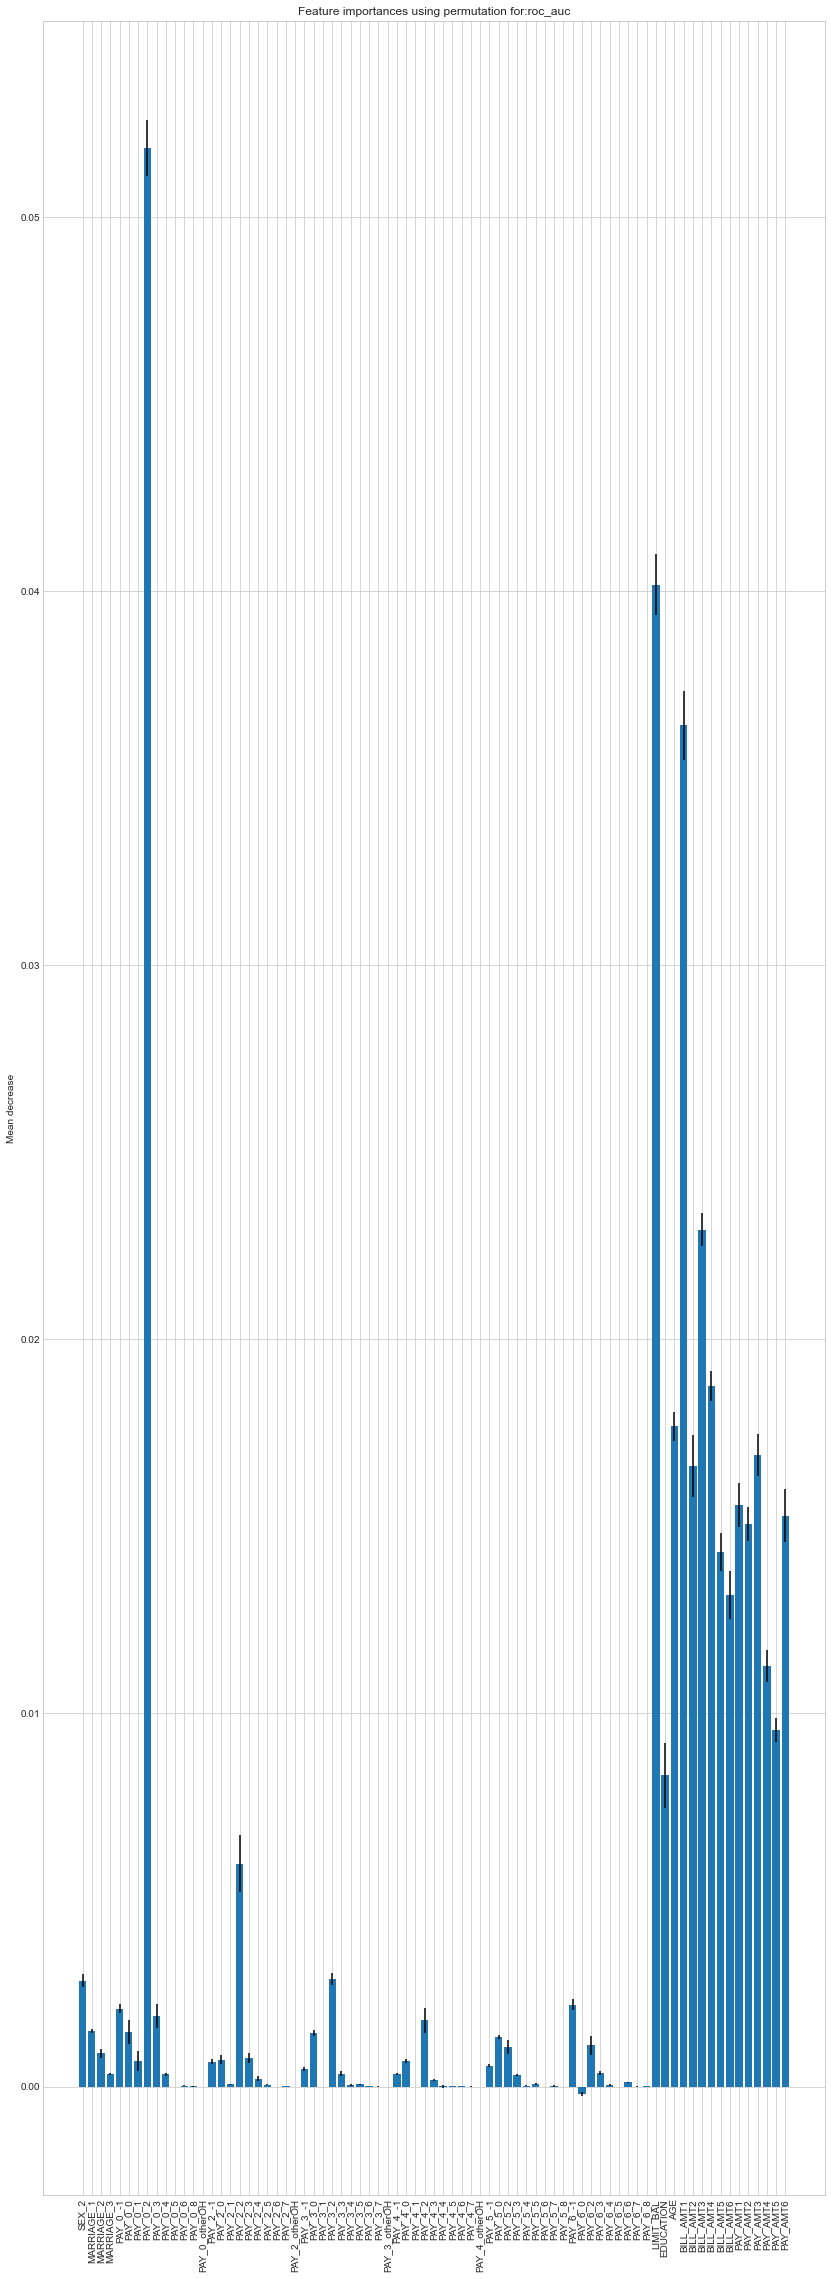

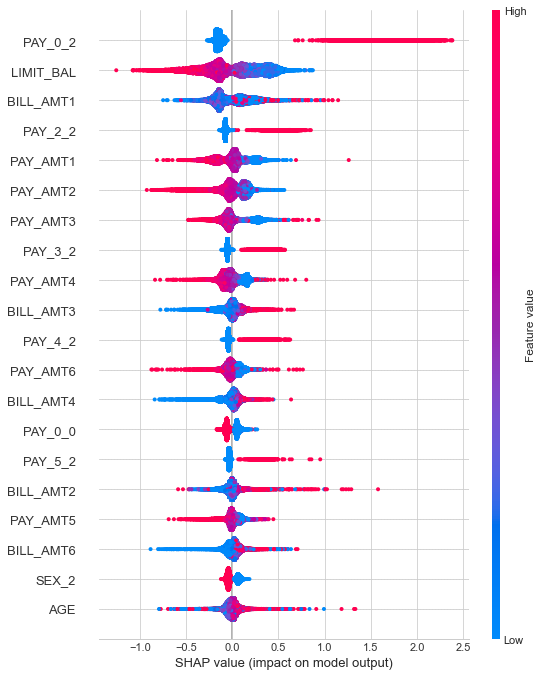

Features below shap importance threshold: PAY_0_5 4.1636646795505303e-05
Features below shap importance threshold: PAY_0_6 0.00013083938235104714
Features below shap importance threshold: PAY_0_8 7.415249367106891e-05
Features below shap importance threshold: PAY_0_otherOH 4.099515429374773e-05
Features below shap importance threshold: PAY_2_1 0.0002824204251959352
Features below shap importance threshold: PAY_2_5 0.0004353941008841546
Features below shap importance threshold: PAY_2_6 0.00017228176145912979
Features below shap importance threshold: PAY_2_7 3.58061362676192e-05
Features below shap importance threshold: PAY_2_otherOH 1.7138245457148954e-06
Features below shap importance threshold: PAY_3_1 3.687622800587373e-06
Features below shap importance threshold: PAY_3_4 0.0004215132448675123
Features below shap importance threshold: PAY_3_5 0.00018947314601075636
Features below shap importance threshold: PAY_3_6 9.448559218256671e-05
Features below shap importance threshold: PAY_3_

In [958]:
y=df[target]
X=df.drop(columns=[target])

m=CatBoostClassifier(silent=True,random_state=randomSeed)
m.fit(X,y)

toDropPermutation=featurePermutation(m, X,y, 5, randomSeed, mainMetric,permutationTreshold)
toDropShap=shapExplain(X,y,m,randomSeed)

print("\nFeatures to drop per Permutation:",len(toDropPermutation),"out of total column number =",len(X.columns))
print("Features to drop per Shap:",len(toDropShap),"out of total column number =",len(X.columns))
intersectionDrop= intersection(toDropPermutation,toDropShap)
selectionColumnDropCount=len(intersectionDrop)


## Stage 'tree-based feature selection'

In [959]:
sampler=""
print("Computing metrics for all model for stage featureSelection")
df.drop(columns=intersectionDrop,inplace=True)
print("We dropped",len(intersectionDrop),"intersecting features, out of total",len(X.columns))
stageResults['featureSelection']=processAllModels(df, mainMetric, randomSeed,"","")
print("\nStage featureSelection results:")
print(stageResults)

Computing metrics for all model for stage featureSelection
We dropped 18 intersecting features, out of total 77
Size of X training set is  (20975, 59)
Size of X validation set is (8990, 59)
Target count: negative, positive 16334 4641
For classifier catboost roc_auc is 0.78
For classifier logregress roc_auc is 0.774
Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_951 (Dense)           (None, 30)                1800      
                                                                 
 dense_952 (Dense)           (None, 1)                 31        
                                                                 
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________
None
281/281 [==============================] - 0s 763us/step - loss: 0.4343 - auc_32: 0.7770
For classifier ffnn roc_auc is 0.77

## Re-sampling Stage
Will use SMOTE over-sampling and ENN under-sampling 

In [960]:
# ENN
print("\nStart ENN under-sampling stage")
sampler=EditedNearestNeighbours(sampling_strategy='majority')
stageResults['ENN']=(processAllModels(df, mainMetric, randomSeed,sampler,""))
print("\nStage ENN sub-sampling results:")
print(stageResults)
    
# smote
print("\nStart SMOTE over-sampling stage")
sampler=SMOTE(random_state=randomSeed)
stageResults['SMOTE']=(processAllModels(df, mainMetric, randomSeed,sampler,""))
print("\nStage SMOTE sub-sampling results:")
print(stageResults)
        


Start ENN under-sampling stage
Size of X training set is  (20975, 59)
Size of X validation set is (8990, 59)
Target count: negative, positive 16334 4641
After resampling, size of training data is (14655, 59) . Validation set is unchanged
Target count: negative, positive 10014 4641
For classifier catboost roc_auc is 0.78
For classifier logregress roc_auc is 0.776
Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_960 (Dense)           (None, 30)                1800      
                                                                 
 dense_961 (Dense)           (None, 1)                 31        
                                                                 
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________
None
281/281 [==============================] - 0s 759us/step - loss: 0.5443 - a

In [961]:
# Based on results above, decide if you should resample or not
resamplerValue= sampler # from above, or
resamplerValue = "" # default, no resampling

## Stage: training loss weight adjustment
We make the loss larger for the minority class

In [962]:
# Model itself decides what weight to give to each label value, usually according to imbalance percentage
stageResults['weightLossAuto']=processAllModels(df, mainMetric, randomSeed,resamplerValue,'auto')
print("\nStage weightLossAuto results:")
print(stageResults)
# For comparison, we enforce here a ratio of imbalanceLossWeightRatio, just to compare with default above
stageResults['weightLossCustom']=processAllModels(df, mainMetric, randomSeed,resamplerValue,imbalanceLossWeightRatio)
print("\nStage weightLossCustom results:")
print(stageResults)

Size of X training set is  (20975, 59)
Size of X validation set is (8990, 59)
Target count: negative, positive 16334 4641
Weight mode is auto Weight ratio is 3.52
For classifier catboost roc_auc is 0.776
For classifier logregress roc_auc is 0.774
Model: "sequential_232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_978 (Dense)           (None, 30)                1800      
                                                                 
 dense_979 (Dense)           (None, 1)                 31        
                                                                 
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________
None
281/281 [==============================] - 0s 896us/step - loss: 0.5514 - auc_35: 0.7773
For classifier ffnn roc_auc is 0.777
Contamination set to 0.22125813449023857
For classifier iForest roc_

In [963]:
# Based on above, pick the appropriate amount of loss weight you want to apply, by default, auto
# note that if resamplerValue value is not empty, then lossWeightValue should be set to empty ("")
lossWeightValue="auto"

## Final metric values and graphs
### Normalized metrics, from 0 (matches baseline categorizer) to 1.0 (perfect prediction)
See https://medium.com/@lermantp/imbalanced-datasets-a-case-for-normalized-metric-gain-b61afc753d3e#67ab-5369f80ddbbf

In [964]:
import copy

stageResultsNormal=copy.deepcopy(stageResults)
for i in stageResults:
    for j in stageResults[i]:
        stageResultsNormal[i][j]=round((stageResults[i][j]-baseline)/(1-baseline),3)
print("Final stageResultsNormal results for test file",testFile)
print("Total number of non-null samples:",df.shape[0],". Number of columns after feature engineering:",df.shape[1])
print("columns dropped by feature collinearity:",colinColumnDropCount,"columns dropped by feature selection:",selectionColumnDropCount,", number of outliers identified:",outlierTotalCount)
print("Baseline value for metric",mainMetric,"is",baseline,". Percent of positive labels is",round(100.0*positivePercent,3),":\n",stageResultsNormal)

Final stageResultsNormal results for test file defaultCreditCard
Total number of non-null samples: 29965 . Number of columns after feature engineering: 60
columns dropped by feature collinearity: 0 columns dropped by feature selection: 18 , number of outliers identified: 7151
Baseline value for metric roc_auc is 0.5 . Percent of positive labels is 22.12 :
 {'initial': {'catboost': 0.558, 'logregress': 0.298, 'ffnn': 0.022, 'iForest': 0.276, 'autoencoder': -0.192}, 'powerTransform': {'catboost': 0.558, 'logregress': 0.548, 'ffnn': 0.552, 'iForest': 0.342, 'autoencoder': 0.078}, 'powerTransformNoOL': {'catboost': 0.554, 'logregress': 0.542, 'ffnn': 0.546, 'iForest': 0.316, 'autoencoder': 0.162}, 'collinearity': {'catboost': 0.558, 'logregress': 0.548, 'ffnn': 0.552, 'iForest': 0.326, 'autoencoder': 0.078}, 'featureSelection': {'catboost': 0.56, 'logregress': 0.548, 'ffnn': 0.554, 'iForest': 0.306, 'autoencoder': 0.08}, 'ENN': {'catboost': 0.56, 'logregress': 0.552, 'ffnn': 0.55, 'iForest

### Graphs

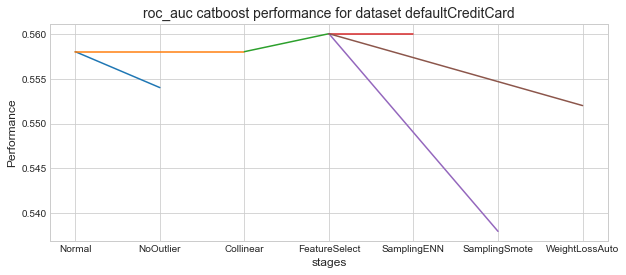

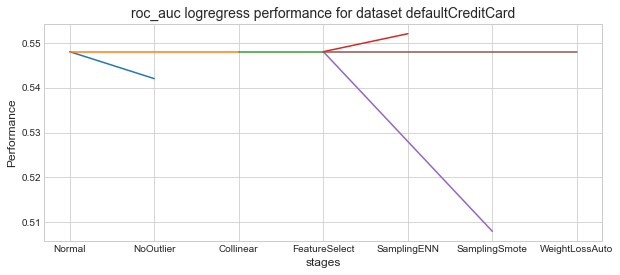

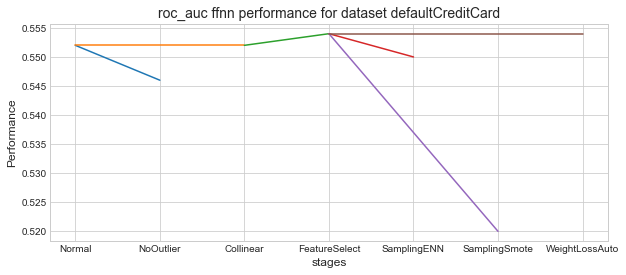

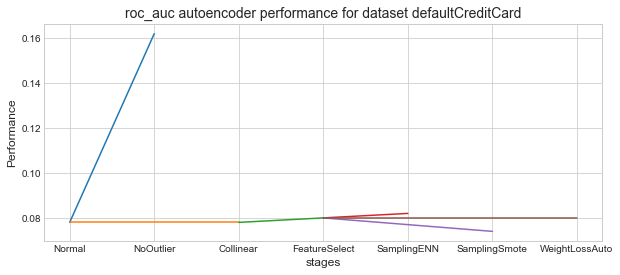

In [965]:
# Graphs

for algo in ['catboost','logregress','ffnn','autoencoder']:
    fig = plt.figure(figsize=(10,4))#if say 2 horizontal plots
    plt.xlabel("stages",fontsize=12)
    plt.ylabel("Performance",fontsize=12)
    title=mainMetric+' '+algo+" performance"+' for dataset'+' '+testFile
    plt.title(title,fontsize=14)
    normal=stageResultsNormal['powerTransform'][algo]
    noOutlier=stageResultsNormal['powerTransformNoOL'][algo]
    collinear=stageResultsNormal['collinearity'][algo]
    featureSelect=stageResultsNormal['featureSelection'][algo]
    ENN=stageResultsNormal['ENN'][algo]
    SMOTE=stageResultsNormal['SMOTE'][algo]
    weightLossAuto=stageResultsNormal['weightLossAuto'][algo]

    #normalize, noOutlier
    x=[0,1]
    y=[normal,noOutlier]
    plt.plot(x,y)

    #normalize, collinear
    x=[0,2]
    y=[normal,collinear]
    plt.plot(x,y)

    #featureSelect from collinear
    x=[2,3]
    y=[collinear,featureSelect]
    plt.plot(x,y)


    #enn from featureSelect
    x=[3,4]
    y=[featureSelect,ENN]
    plt.plot(x,y)

    #smote from featureSelect
    x=[3,5]
    y=[featureSelect,SMOTE]
    plt.plot(x,y)

    #weightLossAuto from featureSelect
    x=[3,6]
    y=[featureSelect,weightLossAuto]
    plt.plot(x,y)

    x=[0,1,2,3,4,5,6]
    plt.xticks(ticks=x,labels=['Normal','NoOutlier','Collinear','FeatureSelect','SamplingENN','SamplingSmote','WeightLossAuto'])
    plt.show()